# Transfer learning for health_fact text classification

In this notebook I fine tunned a transformer model for classification on health_fact data taken from [health_fact](https://huggingface.co/datasets/health_fact).


### Import packages

In [1]:
# Importing libraries
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn import metrics
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
import pickle as pkl

from setting import *  # model parameters
import data_prep as dtp  # Loading data to NN and cleaning
from bert_model import BERTClass # creating the model

# set up device
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

# random seed
np.random.seed(10)

/home/leila/.local/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


### Data Exploring

In [2]:
from datasets import load_dataset
dataset = load_dataset("health_fact")
df_train = dataset['train'].to_pandas()

df_train.head(5)

Using custom data configuration default
Reusing dataset health_fact (/home/leila/.cache/huggingface/datasets/health_fact/default/1.1.0/99503637e4255bd805f84d57031c18fe4dd88298f00299d56c94fc59ed68ec19)


,claim,claim_id,date_published,explanation,fact_checkers,label,main_text,sources,subjects
0,"""The money the Clinton Foundation took from fr...",15661,"April 26, 2015","""Gingrich said the Clinton Foundation """"took m...",Katie Sanders,0,"""Hillary Clinton is in the political crosshair...",https://www.wsj.com/articles/clinton-foundatio...,"Foreign Policy, PunditFact, Newt Gingrich,"
1,Annual Mammograms May Have More False-Positives,9893,"October 18, 2011",This article reports on the results of a study...,,1,While the financial costs of screening mammogr...,,"Screening,WebMD,women's health"
2,SBRT Offers Prostate Cancer Patients High Canc...,11358,"September 28, 2016",This news release describes five-year outcomes...,"Mary Chris Jaklevic,Steven J. Atlas, MD, MPH,K...",1,The news release quotes lead researcher Robert...,https://www.healthnewsreview.org/wp-content/up...,"Association/Society news release,Cancer"
3,"Study: Vaccine for Breast, Ovarian Cancer Has ...",10166,"November 8, 2011","While the story does many things well, the ove...",,2,"The story does discuss costs, but the framing ...",http://clinicaltrials.gov/ct2/results?term=can...,"Cancer,WebMD,women's health"
4,Some appendicitis cases may not require ’emerg...,11276,"September 20, 2010",We really don’t understand why only a handful ...,,2,"""Although the story didn’t cite the cost of ap...",,


In [3]:
print(f'The data has the following columns: \n \n{df_train.keys().tolist()}')

The data has the following columns: 
 
['claim', 'claim_id', 'date_published', 'explanation', 'fact_checkers', 'label', 'main_text', 'sources', 'subjects']


'Claim' is concluded form the 'main_text'. Let's look at word distribution in these two attributes.

In [4]:
df_train['claim'].apply(
    lambda s: len(s.split())).describe()

count    9832.000000
mean       13.934906
std        15.677311
min         0.000000
25%         8.000000
50%        11.000000
75%        17.000000
max       779.000000
Name: claim, dtype: float64

In [5]:
df_train['main_text'].apply(
    lambda s: len(s.split())).describe()

count    9832.000000
mean      711.881001
std       513.193488
min         0.000000
25%       377.000000
50%       607.000000
75%       914.000000
max      7067.000000
Name: main_text, dtype: float64

Since the number of words in 'main_text' is large, and the number of tokens in bert is limited, I will choose the top k sentences which are the most simillar to the claim. This code took a while to run. I ran using the code "" and saved the results as '.pkl' files and imported in next part.

In [6]:
unique_label = df_train['label'].unique()
num_label = len(np.where(unique_label>=0)[0])
unique_label = np.sort(unique_label)
unique_label

array([-1,  0,  1,  2,  3])

These labels corresponds to "true", "false", "unproven" and "mixture". "-1" value is for classes other than the 4 mentioned classes.

# of data with label -1: 28
# of data with label 0: 3001
# of data with label 1: 1434
# of data with label 2: 5078
# of data with label 3: 291


Text(0, 0.5, 'count')

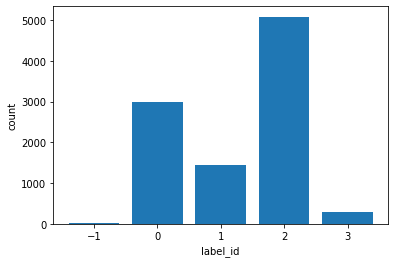

In [7]:
num_class = []
for i in unique_label:
    num_class += [df_train[df_train['label']==i].shape[0]]
    print(f'# of data with label {i}: {num_class[-1]}')
    
import matplotlib.pyplot as plt
plt.bar(unique_label, num_class)
plt.xlabel('label_id')
plt.ylabel('count')

The number of -1 class is not significant (28). So I will remove them from the dataset. The rest of the data are unbalanced. So I need to take care of it. I applied weights to the loss function to include the imbalanced data. The weights are calculated later.

### Data Preprocessing

The -1 labels are removed. Then the top 5 sentences in 'main_text' which are most simillar to 'claim' are chosen. The top 5 sentences and the claim are stored as 'picked_sen' in the dataframe. The code are as follwoing. However, I ran it once, and saved the data. So Later I will just load the data.

In [8]:
# name = 'test'
# dtp.Preprocess(dataset, name, K=5)

# name = 'train'
# dtp.Preprocess(dataset, name, K=5)

#### Loading Preprocessed data

In [10]:
train = pd.read_pickle("./output/train.pkl")
test = pd.read_pickle("./output/test.pkl")

Let's look at the distribution of the picked_sen.

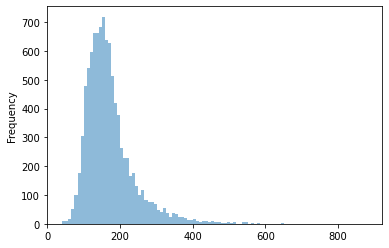

In [11]:

dist = train['picked_sen'].apply(
    lambda s: len(s.split()))
dist.plot.hist(bins=100, alpha=0.5)

I choose max_length of tokens=300.

In [12]:
# Finding the weights of imbalanced data
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced' ,np.unique(train['label']) ,train['label'])
weights = torch.tensor(class_weight,dtype=torch.float)

These weights will be used to handle the unbalance data.

### Data Loader


In [14]:
# print("VAL Dataset: {}".format(validation.shape))
print("TRAIN Dataset: {}".format(train.shape))
print("TEST Dataset: {}".format(test.shape))

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
training_set = dtp.HealthDataset(train, tokenizer, MAX_LEN)
testing_set = dtp.HealthDataset(test, tokenizer, MAX_LEN)

TRAIN Dataset: (9804, 3)
TEST Dataset: (1233, 3)


### Creating NN for fine tunning

In [15]:
training_loader = DataLoader(training_set, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
testing_loader = DataLoader(testing_set, batch_size=VALID_BATCH_SIZE, shuffle=True)

In [16]:
model = BERTClass()
model.to(device)

BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    

In [17]:
# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(params= model.parameters(), lr=LEARNING_RATE)

### Fine tunning the model

In [19]:
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask)
        loss = loss_function(outputs, targets)
        train_loss += loss.item()
#         max_val_train, max_id_train = torch.max(outputs.data, dim=1)
        if _%100==0:
            print('Epoch: ', epoch )
            print("\r" + "{0}/{1} loss: {2} ".format(_, len(train) / TRAIN_BATCH_SIZE, train_loss / (_ + 1)))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
#     y_train = torch.cat((y_train, max_id_train), 0)
    output_model_file = './model/model_' + str(epoch) + '.bin' 
    output_vocab_file = './model/vocab_' + str(epoch) + '.bin'
    torch.save(model, output_model_file)
    tokenizer.save_vocabulary(output_vocab_file)


Epoch:  0
0/612.75 loss: 1.3957098722457886 
Epoch:  0
100/612.75 loss: 1.3860997091425526 
Epoch:  0
200/612.75 loss: 1.3700034232875007 
Epoch:  0
300/612.75 loss: 1.3602544192063848 
Epoch:  0
400/612.75 loss: 1.3538941356012055 
Epoch:  0
500/612.75 loss: 1.3443904206186474 
Epoch:  0
600/612.75 loss: 1.334652896927121 
Epoch:  1
0/612.75 loss: 1.1887375116348267 
Epoch:  1
100/612.75 loss: 1.2237645558791586 
Epoch:  1
200/612.75 loss: 1.2309113823952367 
Epoch:  1
300/612.75 loss: 1.221861411170706 
Epoch:  1
400/612.75 loss: 1.2070005907679437 
Epoch:  1
500/612.75 loss: 1.200740755437139 
Epoch:  1
600/612.75 loss: 1.1869384876503524 
Epoch:  2
0/612.75 loss: 1.2182551622390747 
Epoch:  2
100/612.75 loss: 1.121881628390586 
Epoch:  2
200/612.75 loss: 1.0952769298458573 
Epoch:  2
300/612.75 loss: 1.0950897642940383 
Epoch:  2
400/612.75 loss: 1.0899927000749736 
Epoch:  2
500/612.75 loss: 1.0853771574482947 
Epoch:  2
600/612.75 loss: 1.079885616774567 
Epoch:  3
0/612.75 loss:

Unfortunately I couldn't run the code on gcp. This model is not converged yet. Moreover, I didn't perform hyperparameter tunning using the validation set. 

Anyway I brought the results for the model in next section.

### Model Evaluation

In [26]:
model = torch.load('./model/model_3.bin')
model.eval()
n_correct = 0; n_wrong = 0; total = 0;tr_loss=0
nb_tr_examples=0;nb_tr_steps=0
y_test = torch.empty((0))
with torch.no_grad():
    for _, data in enumerate(testing_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
#         targets = data['targets'].to(device, dtype = torch.long)
        
        Prob_test = model(ids, mask)
        max_val_test, max_id_test = torch.max(Prob_test.data, dim=1)
        y_test = torch.cat((y_test, max_id_test), 0)


In [27]:
from sklearn.metrics import classification_report
print(classification_report(test['label'].tolist(), y_test, labels=[0, 1, 2, 3]))

              precision    recall  f1-score   support

           0       0.33      0.13      0.19       388
           1       0.17      0.26      0.21       201
           2       0.49      0.38      0.43       599
           3       0.04      0.31      0.08        45

    accuracy                           0.28      1233
   macro avg       0.26      0.27      0.23      1233
weighted avg       0.37      0.28      0.30      1233

